In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [122]:
indoorSensor = pd.read_csv('channel_2_data.csv')
outdoorSensor = pd.read_csv('channel_1_data.csv')

# Convert to datetime
indoorSensor['created_at'] = pd.to_datetime(indoorSensor['created_at'])
outdoorSensor['created_at'] = pd.to_datetime(outdoorSensor['created_at'])

indoorSensor.drop(columns=['entry_id'], inplace=True)
outdoorSensor.drop(columns=['entry_id'], inplace=True)

# Set the index to created_at
indoorSensor.set_index('created_at', inplace=True)
outdoorSensor.set_index('created_at', inplace=True)


In [123]:
#Calculate interquartile range and remove outliers
Q1 = indoorSensor.quantile(0.25)
Q3 = indoorSensor.quantile(0.75)

IQR = Q3 - Q1
indoorSensor = indoorSensor[~((indoorSensor < (Q1 - 1.5 * IQR)) |(indoorSensor > (Q3 + 1.5 * IQR))).any(axis=1)]

#print the ranges of the data
print(f"lower limit: {Q3+1.5*IQR} upper Limit: {Q1-1.5*IQR}")

Q1 = outdoorSensor.quantile(0.25)
Q3 = outdoorSensor.quantile(0.75)
IQR = Q3 - Q1
outdoorSensor = outdoorSensor[~((outdoorSensor < (Q1 - 1.5 * IQR)) |(outdoorSensor > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"lower limit: {Q3+1.5*IQR} upper Limit: {Q1-1.5*IQR}")

lower limit: field1     31.308100
field2     75.279564
field3    186.288315
field4    333.034145
dtype: float64 upper Limit: field1    23.860100
field2    51.588094
field3   -34.353325
field4     6.014345
dtype: float64
lower limit: field1     30.568890
field2     60.434963
field3     61.396385
field4    140.539540
dtype: float64 upper Limit: field1    29.534330
field2    49.326942
field3    27.454905
field4    51.364580
dtype: float64


In [124]:
outdoorSensor = outdoorSensor.resample('1min').asfreq()

outdoorSensor.interpolate(method='linear', inplace=True)
outdoorSensor.dropna(inplace=True)

# Linear Interpolate for indoor sensor only if the differnece btween timestamps are less than 10 minutes
indoorSensor = indoorSensor.resample('1min').asfreq()
indoorSensor.interpolate(method='linear', limit=10, inplace=True)
indoorSensor.dropna(inplace=True)
indoorSensor.to_csv('indoorSensor.csv')





In [125]:
# Moving average for outdoor sensor, indoor sensor, add it to a new column
outdoorSensor['pm25Avg'] = outdoorSensor['field3'].rolling(10).mean()
outdoorSensor['pm10Avg'] = outdoorSensor['field4'].rolling(10).mean()
outdoorSensor['temperatureAvg'] = outdoorSensor['field1'].rolling(10).mean()
outdoorSensor['humidityAvg'] = outdoorSensor['field2'].rolling(10).mean()

# Moving average for indoor sensor, include points only if the difference between timestamps are less than 10 minutes
indoorSensor['pm25Avg'] = indoorSensor['field3'].rolling(10).mean()
indoorSensor['pm10Avg'] = indoorSensor['field4'].rolling(10).mean()
indoorSensor['temperatureAvg'] = indoorSensor['field1'].rolling(10).mean()
indoorSensor['humidityAvg'] = indoorSensor['field2'].rolling(10).mean()

# save to csv
outdoorSensor.to_csv('outdoorSensor.csv')
indoorSensor.to_csv('indoorSensor.csv')


In [126]:
# Find the Correlation between indoor and outdoor sensor
print(f"Correlation between indoor and outdoor sensor: {indoorSensor.corrwith(outdoorSensor)}")


# Finding Coefficient of Variability
print(f"CoV for indoor sensor: {indoorSensor.std() * 100/indoorSensor.mean()}")

Correlation between indoor and outdoor sensor: field1            0.157822
field2            0.869966
field3            0.536653
field4            0.595836
pm25Avg           0.211047
pm10Avg           0.261729
temperatureAvg    0.150018
humidityAvg       0.830716
dtype: float64
CoV for indoor sensor: field1             3.813116
field2             5.986568
field3            37.155648
field4            24.229073
pm25Avg           36.261918
pm10Avg           23.590965
temperatureAvg     3.736413
humidityAvg        5.859962
dtype: float64


Longest common time period: 2023-11-18 13:46:00+00:00 to 2023-11-20 19:14:00+00:00


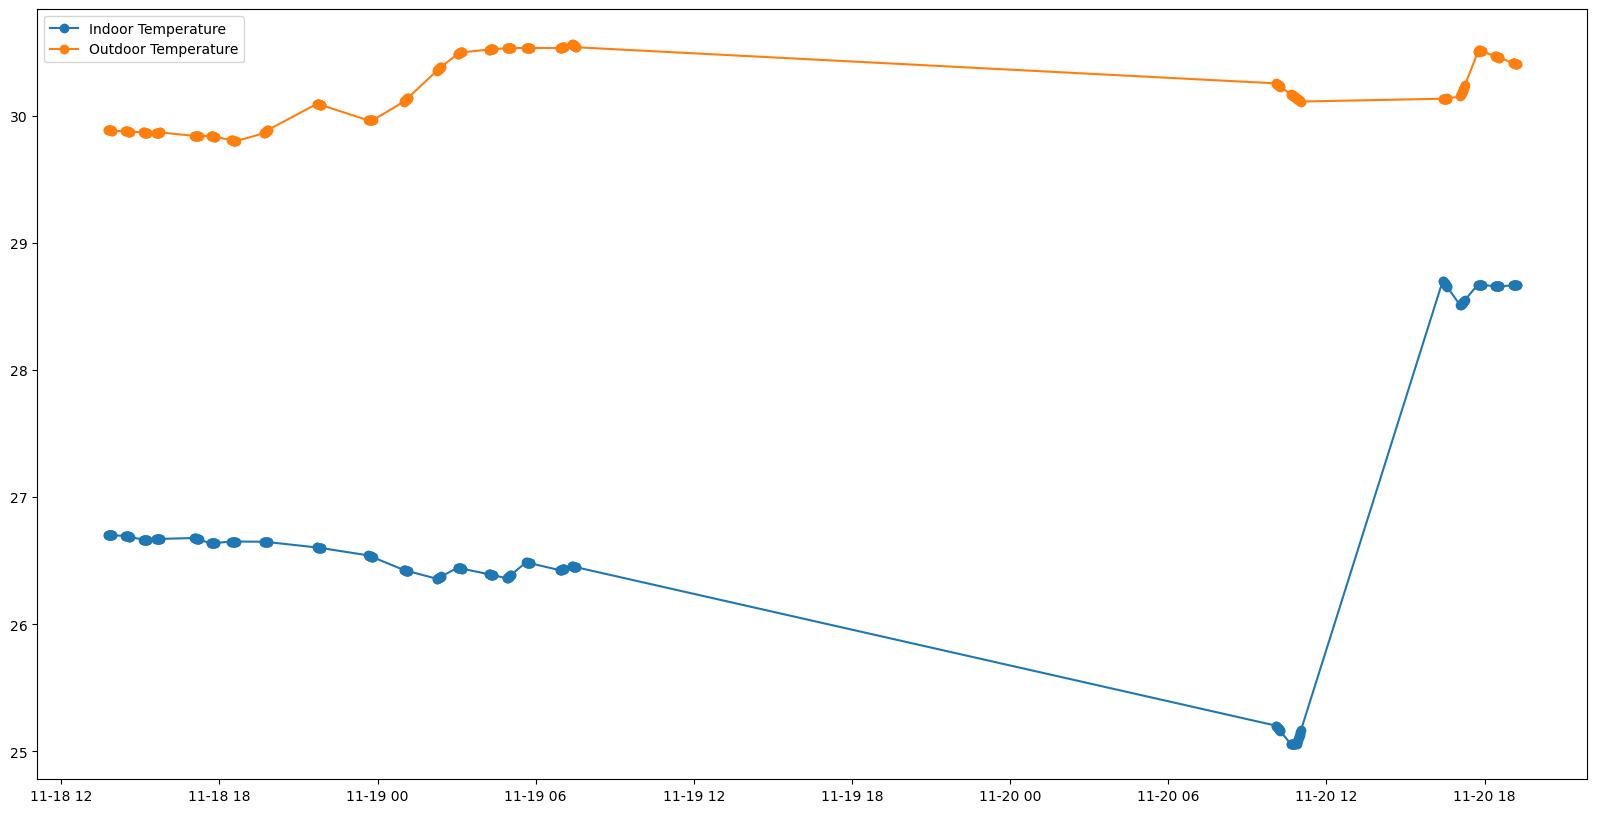

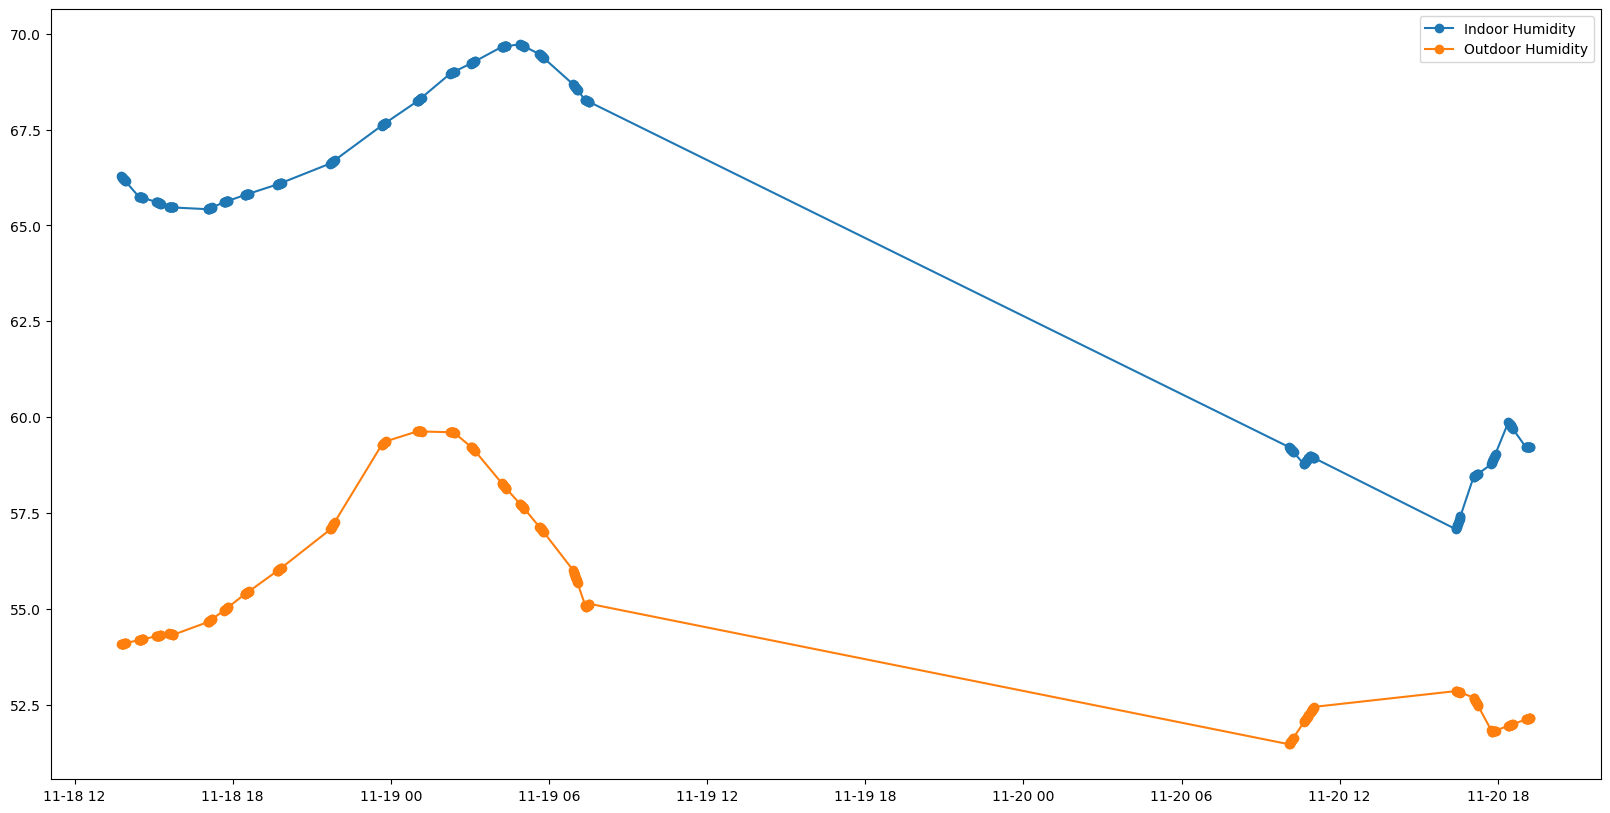

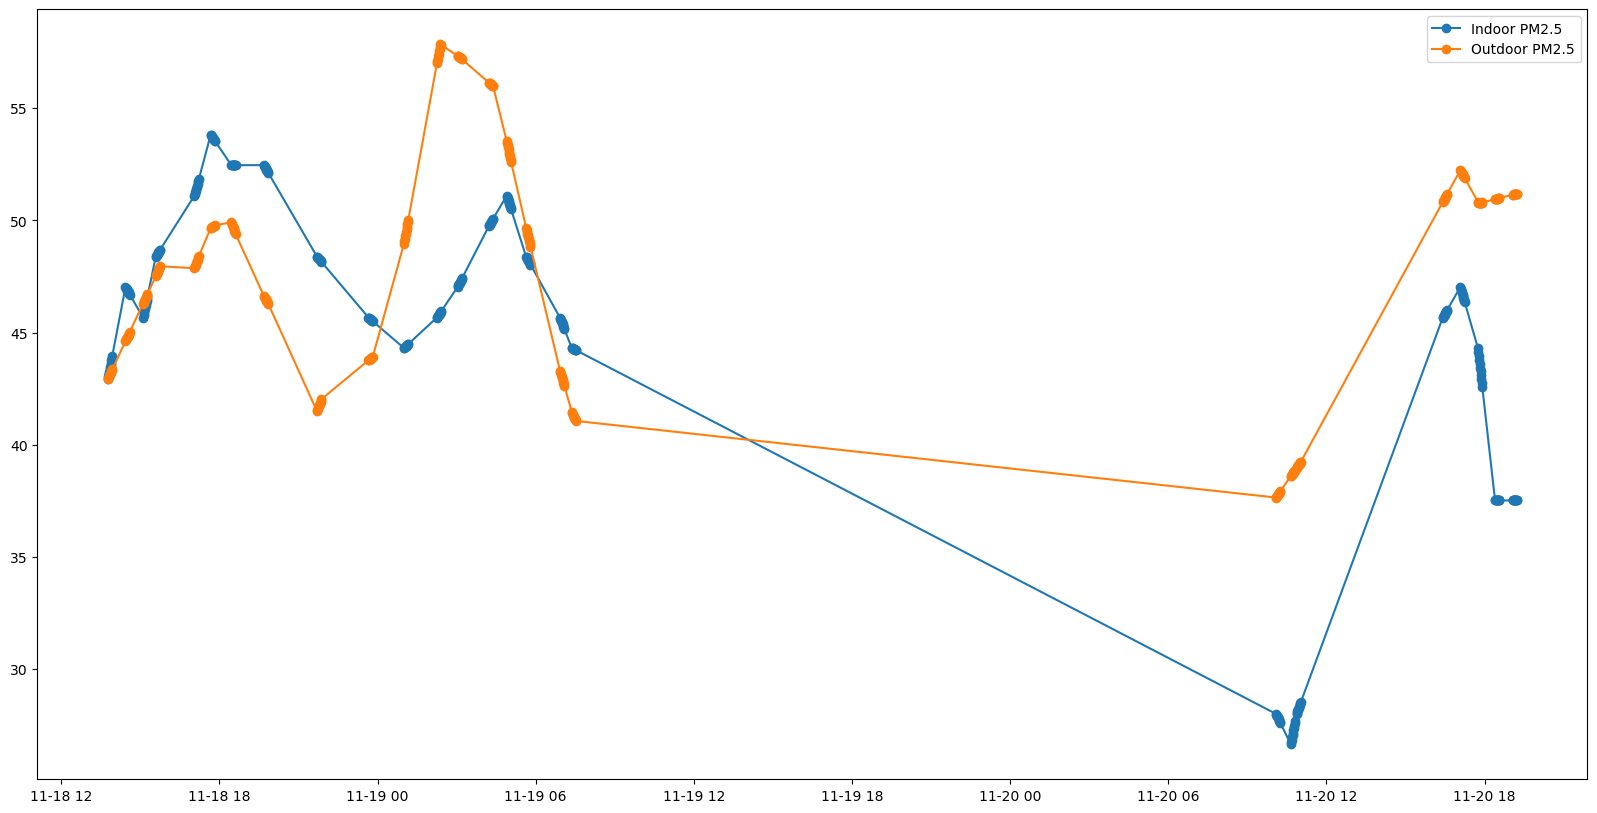

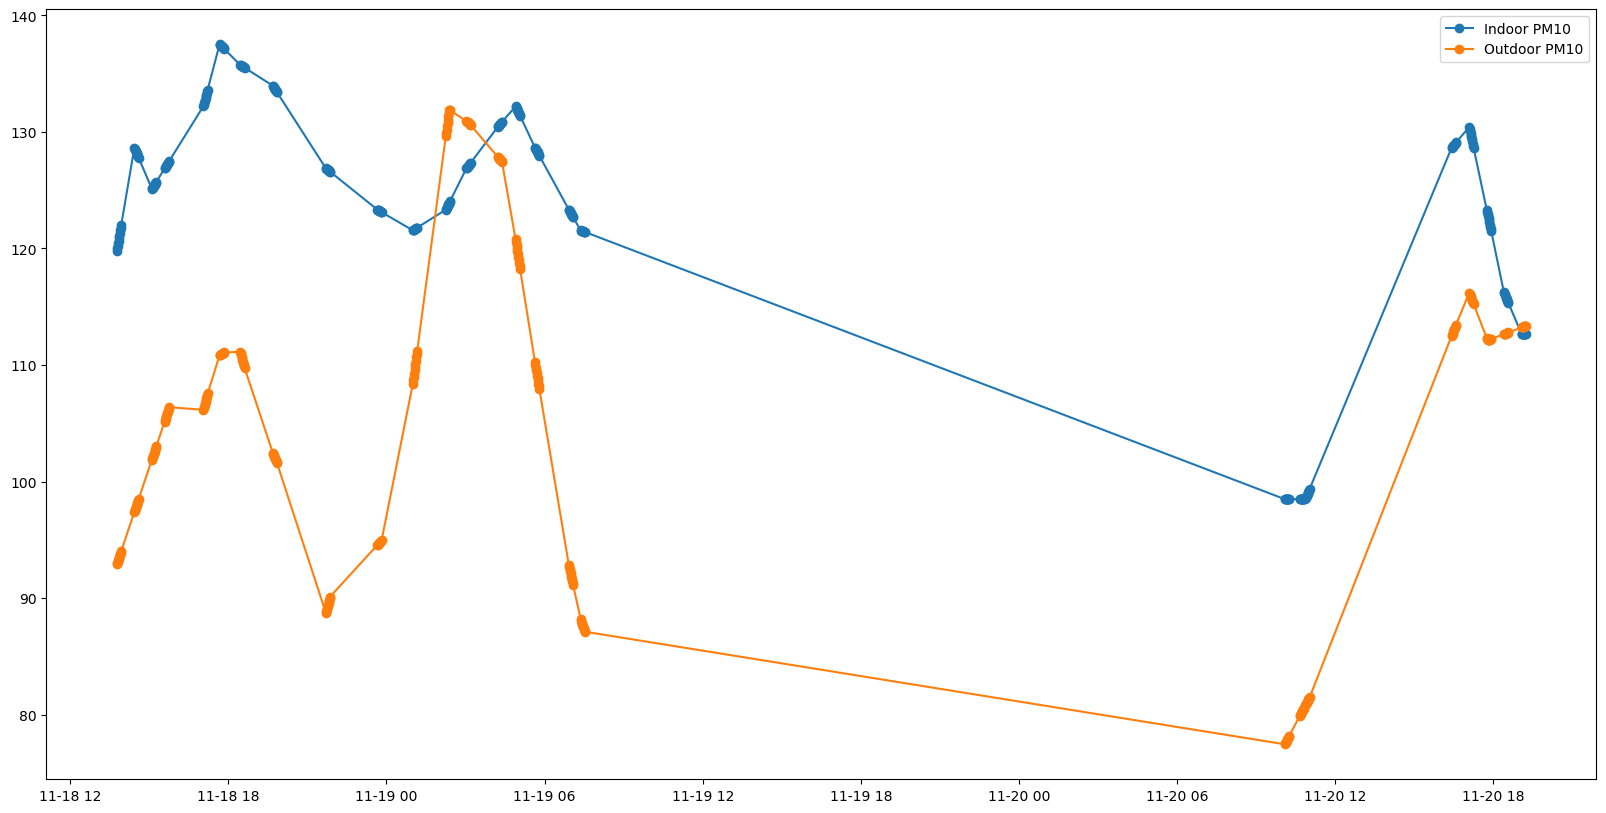

In [127]:
# Finding the longest common timeperiod between indoor and outdoor sensor and plot it
commonTimePeriod = indoorSensor.index.intersection(outdoorSensor.index)
indoorSensorNew = indoorSensor.loc[commonTimePeriod]
outdoorSensorNew = outdoorSensor.loc[commonTimePeriod]

print(f"Longest common time period: {commonTimePeriod[0]} to {commonTimePeriod[-1]}")

# Plot the indoor and outdoor sensor data temperature, humidity, pm25, pm10
#change the marker style

plt.figure(figsize=(20,10))
plt.plot(indoorSensorNew.index, indoorSensorNew['field1'], label='Indoor Temperature', marker='o')
plt.plot(outdoorSensorNew.index, outdoorSensorNew['field1'], label='Outdoor Temperature', marker='o')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(indoorSensorNew.index, indoorSensorNew['field2'], label='Indoor Humidity', marker='o')
plt.plot(outdoorSensorNew.index, outdoorSensorNew['field2'], label='Outdoor Humidity', marker='o')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(indoorSensorNew.index, indoorSensorNew['field3'], label='Indoor PM2.5', marker='o')
plt.plot(outdoorSensorNew.index, outdoorSensorNew['field3'], label='Outdoor PM2.5', marker='o')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(indoorSensorNew.index, indoorSensorNew['field4'], label='Indoor PM10', marker='o')
plt.plot(outdoorSensorNew.index, outdoorSensorNew['field4'], label='Outdoor PM10', marker='o')
plt.legend()
plt.show()

In [128]:
indoorSensor.to_json('channel_2_data_preprocessed.json')
outdoorSensor.to_json('channel_1_data_preprocessed.json')
